In [114]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
import datetime
import os
import geopy
import calendar

import cartopy

DEGREE_SIGN = u'\u00B0'

% matplotlib inline

In [20]:
year_start = 1979
year_end = 2016

ys_str = str(year_start+1)
ye_str = str(year_end-1)

In [21]:
LA_lat = 34.0522
LA_lon = 118.2437 # deg west
LA_lon = 180. + (180-LA_lon)

Oroville_dam_lat = 39.5380
Oroville_dam_lon = 121.4831 # deg west
Oroville_dam_lon = 360 - Oroville_dam_lon

SF_lat = 37.7749
SF_lon = 122.4194
SF_lon = 360 - SF_lon

def geo_idx(dd, dd_array):
   """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
   geo_idx = (numpy.abs(dd_array - dd)).argmin()
   return geo_idx

In [22]:
states_shapes = cartopy.io.shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
shapes_reader = cartopy.io.shapereader.Reader(states_shapes)

states_name_list = numpy.array(([i.attributes['name'] for i in shapes_reader.records()]))
for i in shapes_reader.records():
    if i.attributes['name']=='California' and i.attributes['iso_a2']=='US':
        CA_object = i
CA_object_no_islands = CA_object.geometry.geoms[-1] # get the last one (the state of Cali)

# open seasonal totals from LENS

In [52]:
hist_rcp_filename = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/create_ncfiles_seasonal/seasonal_totals_hist_rcp.nc'

hist_rcp_ncfile = netCDF4.Dataset(hist_rcp_filename)
hist_rcp_data = hist_rcp_ncfile.variables['seasonal_total']
hist_rcp_time_var = hist_rcp_ncfile.variables['time']
hist_rcp_time = hist_rcp_time_var[:]
PRECT_lat = hist_rcp_ncfile.variables['lat'][:]
PRECT_lon = hist_rcp_ncfile.variables['lon'][:]

time_datetimes = netCDF4.num2date(hist_rcp_time, hist_rcp_time_var.units, 'standard')
time_datetimes_subset = [t.year in range(year_start,year_end+1) for t in time_datetimes]
lens_seasonal_totals_array = hist_rcp_data[time_datetimes_subset,:,:,:]
time_datetimes = time_datetimes[time_datetimes_subset]

In [53]:
LA_lat_idx = geo_idx(LA_lat, PRECT_lat)
LA_lon_idx = geo_idx(LA_lon, PRECT_lon)

SF_lat_idx = geo_idx(SF_lat, PRECT_lat)
SF_lon_idx = geo_idx(SF_lon, PRECT_lon)

OD_lat_idx = geo_idx(Oroville_dam_lat, PRECT_lat)
OD_lon_idx = geo_idx(Oroville_dam_lon, PRECT_lon)

#REGION_lat_idx, REGION_lon_idx = SF_lat_idx, SF_lon_idx; REGION_NAME = 'SF'
REGION_lat_idx, REGION_lon_idx = LA_lat_idx, LA_lon_idx; REGION_NAME = 'LA'
#REGION_lat_idx, REGION_lon_idx = OD_lat_idx, OD_lon_idx; REGION_NAME = 'OD'

# open precip from GPCP

In [54]:
gpcp_filename = '/Users/baird/Dropbox/_data_observations/GPCP/precip.mon.mean.nc'
gpcp_ncfile = netCDF4.Dataset(gpcp_filename)
gpcp_data = gpcp_ncfile.variables['precip'][:]
lat_gpcp = gpcp_ncfile.variables['lat'][:]
lon_gpcp = gpcp_ncfile.variables['lon'][:]
gpcp_time_var = gpcp_ncfile.variables['time']
gpcp_time_data = gpcp_time_var[:]

gpcp_time_datetimes = netCDF4.num2date(gpcp_time_data, gpcp_time_var.units, 'standard')
gpcp_time_datetimes_subset = [t.year in range(year_start,year_end+1) for t in gpcp_time_datetimes]
gpcp_data = gpcp_data[gpcp_time_datetimes_subset,:,:]
gpcp_time_datetimes = gpcp_time_datetimes[gpcp_time_datetimes_subset]

In [55]:
# calculate number of days in each gpcp month
month_range = numpy.array(( [calendar.monthrange(t.year,t.month)[1] for t in gpcp_time_datetimes ]))
for j in range(gpcp_data.shape[1]):
    for k in range(gpcp_data.shape[2]):
        gpcp_data[:,j,k] = gpcp_data[:,j,k]*month_range

In [56]:
# pick out NDJFM for full years...
NDJFM_indices_gpcp = numpy.array(([t.month in [11,12,1,2,3] for t in gpcp_time_datetimes]), dtype=bool)
NDJFM_indices_gpcp[0:3]=False
NDJFM_indices_gpcp[-2::]=False

J_indices_gpcp = numpy.array(([t.month in [1] for t in gpcp_time_datetimes]), dtype=bool)
J_indices_gpcp[0]=False

In [57]:
gpcp_data_copy = numpy.copy(gpcp_data)
#half_index = int(cruts_data_copy.shape[2]/2)
#cruts_data_copy[:,:,0:half_index]=cruts_data[:,:,half_index::]
#cruts_data_copy[:,:,half_index::]=cruts_data[:,:,0:half_index]

In [58]:
gpcp_data_subset = gpcp_data_copy[:,(lat_gpcp>=PRECT_lat.min())&(lat_gpcp<=PRECT_lat.max()),:]
gpcp_data_subset = gpcp_data_subset[:,:,(lon_gpcp>=PRECT_lon.min())&(lon_gpcp<=PRECT_lon.max())]
lon_gpcp_subset = lon_gpcp[(lon_gpcp>=PRECT_lon.min())&(lon_gpcp<=PRECT_lon.max())]
lat_gpcp_subset = lat_gpcp[(lat_gpcp>=PRECT_lat.min())&(lat_gpcp<=PRECT_lat.max())]

In [59]:
n_seasons = gpcp_time_datetimes[-1].year - gpcp_time_datetimes[0].year

In [31]:
gpcp_seasonal_totals_array = numpy.zeros((n_seasons,gpcp_data_subset.shape[1],gpcp_data_subset.shape[2]))

In [32]:
gpcp_seasonal_totals_array_allvals = numpy.zeros((gpcp_data_subset.shape))
gpcp_data_subset_nanmonths = numpy.copy(gpcp_data_subset)
gpcp_data_subset_nanmonths[NDJFM_indices_gpcp==False,:,:] = numpy.nan
for j in range(lat_gpcp_subset.size):
    for k in range(lon_gpcp_subset.size):
        gpcp_seasonal_totals_array_allvals[:,j,k] = pandas.Series(gpcp_data_subset_nanmonths[:,j,k]).rolling(window=5, center=True).sum()

# subset all non-nan values (should come out to 115 time periods, or n_seasons)
gpcp_seasonal_totals_array = gpcp_seasonal_totals_array_allvals[J_indices_gpcp,:,:]

# open precip from CRU TS

In [33]:
cruts_filename = '/Users/baird/Dropbox/_analysis/attribution_2017/obs/CRU_TS/cru_ts4.01.1901.2016.pre.dat_ORIG.nc'
cruts_ncfile = netCDF4.Dataset(cruts_filename)
cruts_data = cruts_ncfile.variables['pre'][:]
lon_cruts = cruts_ncfile.variables['lon'][:]+180.
lat_cruts = cruts_ncfile.variables['lat'][:]
cruts_time_var = cruts_ncfile.variables['time']
cruts_time_data = cruts_time_var[:]

cruts_time_datetimes = netCDF4.num2date(cruts_time_data, cruts_time_var.units, 'standard')
cruts_time_datetimes_subset = [t.year in range(year_start,year_end+1) for t in cruts_time_datetimes]
cruts_data = cruts_data[cruts_time_datetimes_subset,:,:]
cruts_time_datetimes = cruts_time_datetimes[cruts_time_datetimes_subset]

In [34]:
cruts_data_copy = numpy.copy(cruts_data)
half_index = int(cruts_data_copy.shape[2]/2)
cruts_data_copy[:,:,0:half_index]=cruts_data[:,:,half_index::]
cruts_data_copy[:,:,half_index::]=cruts_data[:,:,0:half_index]

In [35]:
cruts_data_copy[cruts_data_copy<=0.1]=0.0

In [36]:
cruts_data_copy[cruts_data_copy==9.96920997e36]=numpy.nan

In [37]:
# pick out NDJFM for full years...
NDJFM_indices_cruts = numpy.array(([t.month in [11,12,1,2,3] for t in cruts_time_datetimes]), dtype=bool)
NDJFM_indices_cruts[0:3]=False
NDJFM_indices_cruts[-2::]=False

J_indices_cruts = numpy.array(([t.month in [1] for t in cruts_time_datetimes]), dtype=bool)
J_indices_cruts[0]=False

In [38]:
cruts_data_subset = cruts_data_copy[:,(lat_cruts>=PRECT_lat.min())&(lat_cruts<=PRECT_lat.max()),:]
cruts_data_subset = cruts_data_subset[:,:,(lon_cruts>=PRECT_lon.min())&(lon_cruts<=PRECT_lon.max())]
lon_cruts_subset = lon_cruts[(lon_cruts>=PRECT_lon.min())&(lon_cruts<=PRECT_lon.max())]
lat_cruts_subset = lat_cruts[(lat_cruts>=PRECT_lat.min())&(lat_cruts<=PRECT_lat.max())]

# calculate seasonal totals

In [39]:
n_seasons = cruts_time_datetimes[-1].year - cruts_time_datetimes[0].year

In [40]:
cruts_seasonal_totals_array = numpy.zeros((n_seasons,cruts_data_subset.shape[1],cruts_data_subset.shape[2]))

In [41]:
cruts_seasonal_totals_array_allvals = numpy.zeros((cruts_data_subset.shape))
cruts_data_subset_nanmonths = numpy.copy(cruts_data_subset)
cruts_data_subset_nanmonths[NDJFM_indices_cruts==False,:,:] = numpy.nan
for j in range(lat_cruts_subset.size):
    for k in range(lon_cruts_subset.size):
        cruts_seasonal_totals_array_allvals[:,j,k] = pandas.Series(cruts_data_subset_nanmonths[:,j,k]).rolling(window=5, center=True).sum()

# subset all non-nan values (should come out to 115 time periods, or n_seasons)
cruts_seasonal_totals_array = cruts_seasonal_totals_array_allvals[J_indices_cruts,:,:]

# Get landmask for CRU TS

# Get landmask for LENS

In [42]:
landmask_file = '/Users/baird/Dropbox/Precipitation Extremes Project/Whiplash_manuscript/topography_LENS/USGS-gtopo30_0.9x1.25_remap_c051027.nc'
landmask_ncfile = netCDF4.Dataset(landmask_file)
landfrac = landmask_ncfile.variables['LANDFRAC'][:]
landfrac_lat = landmask_ncfile.variables['lat'][:]
landfrac_lon = landmask_ncfile.variables['lon'][:]

In [43]:
landfrac_lat_subset = (landfrac_lat<=PRECT_lat.max()) & (landfrac_lat>=(PRECT_lat.min()-0.5))
landfrac_lon_subset = (landfrac_lon<=PRECT_lon.max()) & (landfrac_lon>=PRECT_lon.min())

In [44]:
landfrac_subset = landfrac[landfrac_lat_subset,:]
landfrac_subset = landfrac_subset[:,landfrac_lon_subset]
landfrac_nanvals = numpy.ones(landfrac_subset.shape)
landfrac_nanvals[landfrac_subset==0] = numpy.nan
landfrac_nanvals[landfrac_nanvals>0] = 1

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


# Get landmask for GPCP

In [45]:
landmask_file = '/Users/baird/Dropbox/_analysis/obs_analysis/OBS_landfrac_oceanfrac_2.5x2.5.nc'
landmask_ncfile = netCDF4.Dataset(landmask_file)
landsea = landmask_ncfile.variables['landsea_int'][:]
landsea_lat = landmask_ncfile.variables['lat'][:]
landsea_lon = landmask_ncfile.variables['lon'][:]

In [46]:
landsea_lat_subset = (landsea_lat<=PRECT_lat.max()+10) & (landsea_lat>=(PRECT_lat.min()-10))
landsea_lon_subset = (landsea_lon<=PRECT_lon.max()+10) & (landsea_lon>=PRECT_lon.min()-10)

In [47]:
landsea_subset = landsea[landsea_lat_subset,:]
landsea_subset = landsea_subset[:,landsea_lon_subset]
landsea_nanvals = numpy.ones(landsea_subset.shape)
landsea_nanvals[landsea_subset==0] = numpy.nan
landsea_nanvals[landsea_nanvals>0] = 1

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


# Plot all data

In [62]:
gpcp_seasonal_totals_mean = numpy.nanmean(gpcp_seasonal_totals_array, axis=0)
cruts_seasonal_totals_mean = numpy.nanmean(cruts_seasonal_totals_array, axis=0)
lens_seasonal_totals_mean = numpy.nanmean(lens_seasonal_totals_array, axis=(0,1))

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


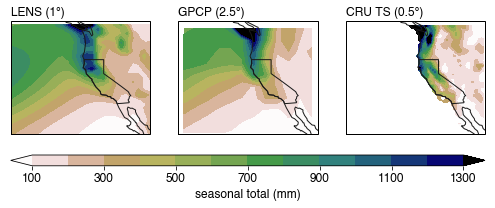

In [129]:
fontsize = 12
fig, axes = mp.subplots(1,3,subplot_kw={'projection':cartopy.crs.PlateCarree()})
fig.set_size_inches(8.5,3)

levels = numpy.arange(100,1301,100)
axes[0].set_extent([PRECT_lon.min(),PRECT_lon.max(),PRECT_lat.min(),PRECT_lat.max()])
axes[1].set_extent([PRECT_lon.min(),PRECT_lon.max(),PRECT_lat.min(),PRECT_lat.max()])
axes[2].set_extent([PRECT_lon.min(),PRECT_lon.max(),PRECT_lat.min(),PRECT_lat.max()])

axes[0].coastlines(resolution='110m',color='0.1')
axes[1].coastlines(resolution='110m',color='0.1')
axes[2].coastlines(resolution='110m',color='0.1')

kw = {'facecolor':'None', 'lw':1, 'edgecolor':'0.1'}
state_outline = axes[0].add_geometries([CA_object_no_islands], crs=cartopy.crs.PlateCarree(), **kw)
state_outline = axes[1].add_geometries([CA_object_no_islands], crs=cartopy.crs.PlateCarree(), **kw)
state_outline = axes[2].add_geometries([CA_object_no_islands], crs=cartopy.crs.PlateCarree(), **kw)

contour1=axes[0].contourf(PRECT_lon,PRECT_lat,lens_seasonal_totals_mean,cmap='gist_earth_r',levels=levels,extend='both')
contour2=axes[1].contourf(lon_gpcp_subset,lat_gpcp_subset,gpcp_seasonal_totals_mean,cmap='gist_earth_r',levels=levels,extend='both')
contour3=axes[2].contourf(lon_cruts_subset,lat_cruts_subset,cruts_seasonal_totals_mean,cmap='gist_earth_r',levels=levels,extend='both')
#contour1=axes[0].pcolor(PRECT_lon,PRECT_lat,lens_seasonal_totals_mean,cmap='gist_earth_r',vmin=levels.min(),vmax=levels.max())
#contour2=axes[1].pcolor(lon_gpcp_subset,lat_gpcp_subset,gpcp_seasonal_totals_mean,cmap='gist_earth_r',vmin=levels.min(),vmax=levels.max())
#contour3=axes[2].pcolor(lon_cruts_subset,lat_cruts_subset,cruts_seasonal_totals_mean,cmap='gist_earth_r',vmin=levels.min(),vmax=levels.max())

axes[0].text(s='LENS (1'+DEGREE_SIGN+')',x=0,y=1.02,fontsize=fontsize,ha='left',va='bottom',transform=axes[0].transAxes)
axes[1].text(s='GPCP (2.5'+DEGREE_SIGN+')',x=0,y=1.02,fontsize=fontsize,ha='left',va='bottom',transform=axes[1].transAxes)
axes[2].text(s='CRU TS (0.5'+DEGREE_SIGN+')',x=0,y=1.02,fontsize=fontsize,ha='left',va='bottom',transform=axes[2].transAxes)

ax_left = axes[0].get_position()
ax_right = axes[2].get_position()
cbar_ax = fig.add_axes([ax_left.x0,ax_left.y0-0.03,ax_right.x1-ax_left.x0,0.05])
cbar = mp.colorbar(contour1,cax=cbar_ax,orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('seasonal total (mm)', fontsize=fontsize)

fig.savefig('obs_seasonal_total_mean_maps_contours.png', bbox_inches='tight', transparent=True, dpi=600)

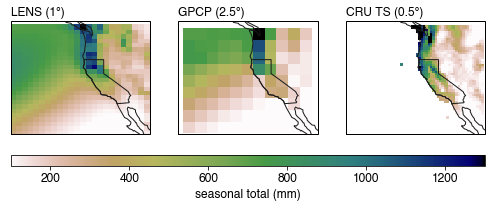

In [130]:
fontsize = 12
fig, axes = mp.subplots(1,3,subplot_kw={'projection':cartopy.crs.PlateCarree()})
fig.set_size_inches(8.5,3)

levels = numpy.arange(100,1301,100)
axes[0].set_extent([PRECT_lon.min(),PRECT_lon.max(),PRECT_lat.min(),PRECT_lat.max()])
axes[1].set_extent([PRECT_lon.min(),PRECT_lon.max(),PRECT_lat.min(),PRECT_lat.max()])
axes[2].set_extent([PRECT_lon.min(),PRECT_lon.max(),PRECT_lat.min(),PRECT_lat.max()])

axes[0].coastlines(resolution='110m',color='0.1')
axes[1].coastlines(resolution='110m',color='0.1')
axes[2].coastlines(resolution='110m',color='0.1')

kw = {'facecolor':'None', 'lw':1, 'edgecolor':'0.1'}
state_outline = axes[0].add_geometries([CA_object_no_islands], crs=cartopy.crs.PlateCarree(), **kw)
state_outline = axes[1].add_geometries([CA_object_no_islands], crs=cartopy.crs.PlateCarree(), **kw)
state_outline = axes[2].add_geometries([CA_object_no_islands], crs=cartopy.crs.PlateCarree(), **kw)

#contour1=axes[0].contourf(PRECT_lon,PRECT_lat,lens_seasonal_totals_mean,cmap='gist_earth_r',levels=levels,extend='both')
#contour2=axes[1].contourf(lon_gpcp_subset,lat_gpcp_subset,gpcp_seasonal_totals_mean,cmap='gist_earth_r',levels=levels,extend='both')
#contour3=axes[2].contourf(lon_cruts_subset,lat_cruts_subset,cruts_seasonal_totals_mean,cmap='gist_earth_r',levels=levels,extend='both')
contour1=axes[0].pcolor(PRECT_lon,PRECT_lat,lens_seasonal_totals_mean,cmap='gist_earth_r',vmin=levels.min(),vmax=levels.max())
contour2=axes[1].pcolor(lon_gpcp_subset,lat_gpcp_subset,gpcp_seasonal_totals_mean,cmap='gist_earth_r',vmin=levels.min(),vmax=levels.max())
contour3=axes[2].pcolor(lon_cruts_subset,lat_cruts_subset,cruts_seasonal_totals_mean,cmap='gist_earth_r',vmin=levels.min(),vmax=levels.max())

axes[0].text(s='LENS (1'+DEGREE_SIGN+')',x=0,y=1.02,fontsize=fontsize,ha='left',va='bottom',transform=axes[0].transAxes,snap=True)
axes[1].text(s='GPCP (2.5'+DEGREE_SIGN+')',x=0,y=1.02,fontsize=fontsize,ha='left',va='bottom',transform=axes[1].transAxes,snap=True)
axes[2].text(s='CRU TS (0.5'+DEGREE_SIGN+')',x=0,y=1.02,fontsize=fontsize,ha='left',va='bottom',transform=axes[2].transAxes,snap=True)

ax_left = axes[0].get_position()
ax_right = axes[2].get_position()
cbar_ax = fig.add_axes([ax_left.x0,ax_left.y0-0.03,ax_right.x1-ax_left.x0,0.05])
cbar = mp.colorbar(contour1,cax=cbar_ax,orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('seasonal total (mm)', fontsize=fontsize)

fig.savefig('obs_seasonal_total_mean_maps_pcolor.png', bbox_inches='tight', transparent=True, dpi=600)

# save netcdf files for these

# lens map

In [141]:
# save hist clim
filename = 'LENS_seasonal_totals_1980-2016.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat.size)
lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lat_var[:] = PRECT_lat
lat_var.units = 'degrees North'

lon_dim = ncfile.createDimension('lon', PRECT_lon.size)
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lon_var[:] = PRECT_lon
lon_var.units = 'degrees East'

data_var = ncfile.createVariable('seasonal_total', 'f4', ('lat','lon',))
data_var[:] = lens_seasonal_totals_mean
data_var.units = 'mm total during NDJFM'

ncfile.close()

file exists


# gpcp map

In [142]:
# save hist clim
filename = 'GPCP_seasonal_totals_1980-2016.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', lat_gpcp_subset.size)
lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lat_var[:] = lat_gpcp_subset
lat_var.units = 'degrees North'

lon_dim = ncfile.createDimension('lon', lon_gpcp_subset.size)
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lon_var[:] = lon_gpcp_subset
lon_var.units = 'degrees East'

data_var = ncfile.createVariable('seasonal_total', 'f4', ('lat','lon',))
data_var[:] = gpcp_seasonal_totals_mean
data_var.units = 'mm total during NDJFM'

ncfile.close()

file exists


In [143]:
cruts_seasonal_totals_mean[numpy.isnan(cruts_seasonal_totals_mean)]=-999.

In [144]:
# save hist clim
filename = 'CRU_TS_seasonal_totals_1980-2016.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', lat_cruts_subset.size)
lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lat_var[:] = lat_cruts_subset
lat_var.units = 'degrees North'

lon_dim = ncfile.createDimension('lon', lon_cruts_subset.size)
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lon_var[:] = lon_cruts_subset
lon_var.units = 'degrees East'

data_var = ncfile.createVariable('seasonal_total', 'f4', ('lat','lon',), fill_value=-999)
data_var[:] = cruts_seasonal_totals_mean
data_var.units = 'mm total during NDJFM'

ncfile.close()

file exists
